<center style="font-size: 2em; font-weight: bold;"> Determinantes de la exportacion de empresas </center>
<center style="font-size: 2em; font-weight: bold;"> Analisis de base de datos  </center>
<left style="font-size: 4em; font-weight: bold;"> Autor: Edinson Tolentino </left>

# Librerias

In [1]:
import pandas
import numpy
import os
import sys
import numpy

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

import sklearn
import sklearn.compose
import category_encoders
import sklearn.impute

from plotnine import *
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

import py_hep_functions
import seaborn
import matplotlib.pyplot as plt

In [2]:

color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]

def seq(start: float, stop: float, by: float, round_n=3) -> list:
    """
    Custom function, used for setting the breaks of plotnine scales.

       Parameters
    ----------
    start : float
        Start of the breaks.
    stop : float
        End of the breaks.
    by : float
        Steps between breaks.
    round_n: int, default=3
        Decimals to round floats in output.
    """
    epsilon = numpy.finfo("float").eps

    return [
        round(x, round_n) for x in list(numpy.arange(start, stop + (by - epsilon), by))
    ]
    
def normalize_frame(frame):
    """Normalize the data frame to make it performant and compatible with
    downstream libraries such as Scikit-Learn and CatBoost.
    
    In particular the following operations are performed:
    - Categorical levels that are not strings are converted into strings
    - Categorical missing values are converted into a distinct "N/A" level
    - Object-typed columns are converted into categorical columns
    """
    for col, series in frame.items():
        dtype = series.dtype
        if pandas.api.types.is_categorical_dtype(dtype):
            recode = False
            if series.hasnans:
                recode = True
            else:
                for value in series.cat.categories:
                    if not isinstance(value, str):
                        recode = True
                        break
            if recode:
                frame[col] = series.astype("str").fillna("N/A").astype(
                    "category")
        elif pandas.api.types.is_object_dtype(dtype):
            frame[col] = series.astype("str").fillna("N/A").astype("category")

    return frame

base_transformer = sklearn.pipeline.Pipeline([
    ("recode", sklearn.compose.ColumnTransformer(transformers=[
        ("category",
             #sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore",
             sklearn.preprocessing.OneHotEncoder(drop="first",handle_unknown="ignore",                                                 
                min_frequency=0.01, max_categories=40, sparse_output= False),
             sklearn.compose.make_column_selector(dtype_exclude=numpy.number)
        ),
        ("number",
            sklearn.impute.SimpleImputer(strategy="mean"),
            sklearn.compose.make_column_selector(dtype_include=numpy.number)
        ),  
    ], n_jobs=-1)),
    #("rescale", sklearn.preprocessing.StandardScaler()),
])

# Analisis

## Data

In [3]:
output           = "C:/Users/et396/Dropbox/Docencia/Educate/Econometria/S2/Data"
os.chdir(output)

# Carga de data
base = pandas.read_stata("ENE_PANEL_Manufacturing.dta")
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   rid              4947 non-null   float32 
 1   ryear            4947 non-null   float32 
 2   rsales           4947 non-null   float32 
 3   rpt              4947 non-null   float32 
 4   rlabor           4947 non-null   float32 
 5   rproductivity    4947 non-null   float32 
 6   redad            4947 non-null   float32 
 7   rexporta         4947 non-null   float32 
 8   region           4947 non-null   category
 9   rciiu2           4947 non-null   float32 
 10  rmype            4947 non-null   float32 
 11  redadsq          4947 non-null   float32 
 12  lnrsales         4947 non-null   float32 
 13  lnrpt            4947 non-null   float32 
 14  lnrlabor         4947 non-null   float32 
 15  lnrproductivity  4947 non-null   float32 
 16  lnredad          4947 non-null   float32 


In [4]:
# Lagged 
base['lnrproductivity_1'] = base.groupby('rid')['lnrproductivity'].shift(-1)
base['redad_1']           = base.groupby('rid')['redad'].shift(-1)
base['redadsq_1']         = base.groupby('rid')['redadsq'].shift(-1)
base['rmype_1']           = base.groupby('rid')['rmype'].shift(-1)


In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   rid                4947 non-null   float32 
 1   ryear              4947 non-null   float32 
 2   rsales             4947 non-null   float32 
 3   rpt                4947 non-null   float32 
 4   rlabor             4947 non-null   float32 
 5   rproductivity      4947 non-null   float32 
 6   redad              4947 non-null   float32 
 7   rexporta           4947 non-null   float32 
 8   region             4947 non-null   category
 9   rciiu2             4947 non-null   float32 
 10  rmype              4947 non-null   float32 
 11  redadsq            4947 non-null   float32 
 12  lnrsales           4947 non-null   float32 
 13  lnrpt              4947 non-null   float32 
 14  lnrlabor           4947 non-null   float32 
 15  lnrproductivity    4947 non-null   float32 
 16  lnreda

In [6]:
base.sample(5).head().T

,2161,1589,4492,1577,2609
rid,340.0,1590.0,704.0,1578.0,788.0
ryear,2016.0,2017.0,2015.0,2017.0,2016.0
rsales,120.0,2226.575928,2446.388916,1010.0,15802.495117
rpt,120.0,894.635986,2446.388916,889.112976,15802.495117
rlabor,2.0,11.0,8.0,2.0,44.0
rproductivity,60.0,202.416,305.798615,505.0,359.147614
redad,10.0,8.0,12.0,8.0,23.0
rexporta,0.0,0.0,1.0,0.0,0.0
region,NORTE,LIMA,ORIENTE,LIMA,LIMA
rciiu2,16.0,25.0,16.0,24.0,29.0


In [7]:
# Filtro de variables
response = ['rexporta']
inputs   = ['lnrproductivity_1','redad_1', 'redadsq_1','rmype_1','region','ryear']
data_analysis = base[response + inputs]

# Normalise informacion : number, category columns
data_fit = normalize_frame(data_analysis)
data_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   rexporta           4947 non-null   float32 
 1   lnrproductivity_1  2980 non-null   float32 
 2   redad_1            2980 non-null   float32 
 3   redadsq_1          2980 non-null   float32 
 4   rmype_1            2980 non-null   float32 
 5   region             4947 non-null   category
 6   ryear              4947 non-null   float32 
dtypes: category(1), float32(6)
memory usage: 121.1 KB


C:\Users\et396\AppData\Local\Temp\ipykernel_26744\1749348307.py:35: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead


## Descripcion

In [8]:
data_fit.describe()

,rexporta,lnrproductivity_1,redad_1,redadsq_1,rmype_1,ryear
count,4947.000000,2980.000000,2980.000000,2980.000000,2980.000000,4947.000000
mean,0.170406,4.595783,15.919463,370.510742,0.661409,2016.134277
std,0.376027,1.174557,10.822233,645.731628,0.473310,0.764518
min,0.000000,0.444686,4.000000,16.000000,0.000000,2015.000000
25%,0.000000,3.806663,8.000000,64.000000,0.000000,2016.000000
50%,0.000000,4.572975,13.000000,169.000000,1.000000,2016.000000
75%,0.000000,5.301802,21.000000,441.000000,1.000000,2017.000000
max,1.000000,10.010289,107.000000,11449.000000,1.000000,2017.000000


In [9]:
data_fit.sample(4).head().T

,610,3479,3421,882
rexporta,0.0,0.0,1.0,0.0
lnrproductivity_1,4.486377,NaN,NaN,6.668758
redad_1,58.0,NaN,NaN,23.0
redadsq_1,3364.0,NaN,NaN,529.0
rmype_1,0.0,NaN,NaN,0.0
region,ORIENTE,LIMA,LIMA,NORTE
ryear,2017.0,2016.0,2016.0,2017.0


In [10]:
data_fit = data_fit.dropna()
data_fit.describe()

,rexporta,lnrproductivity_1,redad_1,redadsq_1,rmype_1,ryear
count,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000
mean,0.130537,4.595783,15.919463,370.510742,0.661409,2016.611450
std,0.336950,1.174557,10.822233,645.731628,0.473310,0.487512
min,0.000000,0.444686,4.000000,16.000000,0.000000,2016.000000
25%,0.000000,3.806663,8.000000,64.000000,0.000000,2016.000000
50%,0.000000,4.572975,13.000000,169.000000,1.000000,2017.000000
75%,0.000000,5.301801,21.000000,441.000000,1.000000,2017.000000
max,1.000000,10.010289,107.000000,11449.000000,1.000000,2017.000000


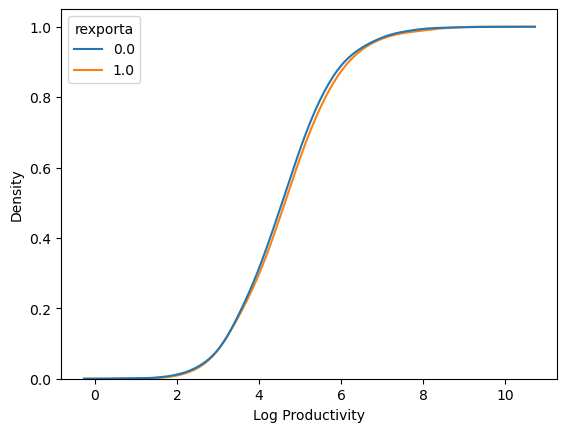

In [11]:
fig3 = seaborn.kdeplot(
    data=data_fit, x="lnrproductivity_1", hue="rexporta",
    cumulative=True, common_norm=False, common_grid=True,
)
fig3.set(xlabel='Log Productivity', ylabel='Density')
plt.show()

In [12]:
data_fit.groupby("rexporta").agg(
    mean_productivity=("lnrproductivity_1", "mean"), mean_redad=("redad_1", "mean")
)

,mean_productivity,mean_redad
rexporta,,
0.0,4.586894,16.107681
1.0,4.654994,14.665810


In [13]:
data_fit.groupby(["rexporta",'region']).agg(
    mean_productivity=("lnrproductivity_1", "mean"), mean_redad=("redad_1", "mean")
).T

C:\Users\et396\AppData\Local\Temp\ipykernel_26744\3253127589.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


rexporta                 0.0                                             \
region                 NORTE        SUR    CENTRO       LIMA    ORIENTE   
mean_productivity   4.669210   4.644285   4.67781   4.506580   4.633834   
mean_redad         16.181406  16.266666  16.66279  15.698004  17.033333   

rexporta                 1.0                                              
region                 NORTE        SUR     CENTRO       LIMA    ORIENTE  
mean_productivity   4.712218   4.721511   4.851922   4.631210   4.521662  
mean_redad         12.750000  17.368422  16.913044  14.356667  11.750000

## Modelos

In [14]:
#data_fit.sample(4).head().T
data_fit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2980 entries, 0 to 2979
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   rexporta           2980 non-null   float32 
 1   lnrproductivity_1  2980 non-null   float32 
 2   redad_1            2980 non-null   float32 
 3   redadsq_1          2980 non-null   float32 
 4   rmype_1            2980 non-null   float32 
 5   region             2980 non-null   category
 6   ryear              2980 non-null   float32 
dtypes: category(1), float32(6)
memory usage: 96.2 KB


In [15]:
response = data_fit[['rexporta']]
predictors_cols1 = ['lnrproductivity_1']
predictors_cols2 = ['lnrproductivity_1', 'redad_1','redadsq_1']
predictors_cols3 = ['lnrproductivity_1', 'redad_1','redadsq_1', 'rmype_1',"region",'ryear']

### Question 1

In [16]:
# Modelo OLS vs Probit
# OLS
base1        = data_fit[predictors_cols1]
predictors  = data_fit[predictors_cols1]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base1.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m0_ols = sm.OLS(response, inputs).fit(cov_type="HC1")

# Probit
base1        = data_fit[predictors_cols1]
predictors  = data_fit[predictors_cols1]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base1.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m0_probit = sm.Probit(response, inputs).fit(cov_type="HC1")

Optimization terminated successfully.
         Current function value: 0.387215
         Iterations 5


In [17]:
stargazer = Stargazer([m0_ols,m0_probit])
stargazer.custom_columns(["MCO", "Probit"], [1,1])
stargazer.covariate_order(["number__lnrproductivity_1"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Efectos fijos Dpto", ["","No"])
stargazer.add_line("Efectos fijos Year", ["","No"])
stargazer

### Question 2

In [18]:
import statsmodels 

base1        = data_fit[predictors_cols1]
predictors  = data_fit[predictors_cols1]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base1.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

#m0 = sm.Probit(response, inputs).fit(cov_type="HC1")
m0 = statsmodels.discrete.discrete_model.Probit(response, inputs).fit(cov_type="HC1")

base2        = data_fit[predictors_cols2]
predictors  = data_fit[predictors_cols2]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base2.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

#m1 = sm.Probit(response, inputs).fit(cov_type="HC1")
m1 = statsmodels.discrete.discrete_model.Probit(response, inputs).fit(cov_type="HC1")


base3        = data_fit[predictors_cols3]
predictors  = data_fit[predictors_cols3]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base3.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

#m2 = sm.Probit(response, inputs).fit(cov_type="HC1")
m2 = statsmodels.discrete.discrete_model.Probit(response, inputs).fit(cov_type="HC1")


Optimization terminated successfully.
         Current function value: 0.387215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355723
         Iterations 8


In [19]:
print(m2.summary())

                          Probit Regression Results                           
Dep. Variable:               rexporta   No. Observations:                 2980
Model:                         Probit   Df Residuals:                     2970
Method:                           MLE   Df Model:                            9
Date:                Fri, 22 Mar 2024   Pseudo R-squ.:                 0.08178
Time:                        20:38:16   Log-Likelihood:                -1060.1
converged:                       True   LL-Null:                       -1154.5
Covariance Type:                  HC1   LLR p-value:                 7.231e-36
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       556.2212    135.463      4.106      0.000     290.718     821.724
category__region_LIMA         0.5853      0.120      4.882      0.000       0.350     

In [20]:
stargazer = Stargazer([m0,m1,m2])
stargazer.custom_columns(["Exportar", "Exporta", "Exporta"], [1,1,1])
stargazer.covariate_order(["number__lnrproductivity_1", 'number__redad_1', 'number__redadsq_1','number__rmype_1'])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Efectos fijos Dpto", ["","","Si"])
stargazer.add_line("Efectos fijos Year", ["","","Si"])
stargazer

In [22]:
# Cual es la edad donde los ingresos de los individuos se reduce
-(m2.params['number__redad_1'] / (2*m2.params['number__redadsq_1']) )
edad_optima = round(-(m2.params['number__redad_1'] / (2*m2.params['number__redadsq_1']) ),0)
edad_optima

39.0

### Question 3

In [23]:
#Average Marginal Effects
margins= m2.get_margeff( at='overall', method='dydx' )
print(margins.summary())

       Probit Marginal Effects       
Dep. Variable:               rexporta
Method:                          dydx
At:                           overall
                               dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
category__region_LIMA         0.1147      0.023      4.924      0.000       0.069       0.160
category__region_NORTE       -0.0607      0.030     -2.035      0.042      -0.119      -0.002
category__region_ORIENTE     -0.1031      0.037     -2.752      0.006      -0.176      -0.030
category__region_SUR          0.0054      0.028      0.195      0.846      -0.049       0.059
number__lnrproductivity_1     0.0004      0.006      0.061      0.951      -0.011       0.012
number__redad_1              -0.0053      0.001     -3.635      0.000      -0.008      -0.002
number__redadsq_1          6.783e-05    2.4e-05      2.829      0.005    2.08e-05       0.000
nu

In [24]:
# Efecto marginal sobre las caracteristicas promedio
margins= m2.get_margeff( at='mean', method='dydx' )
print(margins.summary())

       Probit Marginal Effects       
Dep. Variable:               rexporta
Method:                          dydx
At:                              mean
                               dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
category__region_LIMA         0.1096      0.022      4.929      0.000       0.066       0.153
category__region_NORTE       -0.0580      0.028     -2.046      0.041      -0.114      -0.002
category__region_ORIENTE     -0.0984      0.035     -2.793      0.005      -0.168      -0.029
category__region_SUR          0.0051      0.026      0.195      0.846      -0.047       0.057
number__lnrproductivity_1     0.0003      0.005      0.061      0.951      -0.010       0.011
number__redad_1              -0.0050      0.001     -3.637      0.000      -0.008      -0.002
number__redadsq_1          6.479e-05   2.29e-05      2.828      0.005    1.99e-05       0.000
nu

### Question 4

In [25]:
base3        = data_fit[predictors_cols3]
predictors  = data_fit[predictors_cols3]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base3.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

#m2 = sm.Probit(response, inputs).fit(cov_type="HC1")
m2_p = statsmodels.discrete.discrete_model.Probit(response, inputs).fit(cov_type="HC1")


base3        = data_fit[predictors_cols3]
predictors  = data_fit[predictors_cols3]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base3.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

#m2 = sm.Probit(response, inputs).fit(cov_type="HC1")
m2_l = statsmodels.discrete.discrete_model.Logit(response, inputs).fit(cov_type="HC1")



Optimization terminated successfully.
         Current function value: 0.355723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354943
         Iterations 9


In [26]:
stargazer = Stargazer([m2_p,m2_l])
stargazer.custom_columns(["Probit", "Logit"], [1,1])
stargazer.covariate_order(["number__lnrproductivity_1", 'number__redad_1', 'number__redadsq_1','number__rmype_1'])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Efectos fijos Dpto", ["","Si"])
stargazer.add_line("Efectos fijos Year", ["","Si"])
stargazer